# Read the data

In [ ]:
from connection import * 
import numpy as np
from sqlalchemy import create_engine 
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import math
warnings.filterwarnings('ignore')

DB_HOST = DB_HOST
DB_NAME = DB_NAME
DB_USER = DB_USER       
DB_PASS = DB_PASS       
DB_PORT = DB_PORT              

engine = create_engine(f'postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}')

def get_boolean_columns(engine, schema, table_name):
    """Get the right schema and table name for the boolean columns."""
    query = f"""
            SELECT column_name
            FROM information_schema.columns
            WHERE table_schema = '{schema}' AND table_name = '{table_name}' AND data_type = 'boolean';
            """
    result = pd.read_sql(query, engine)
    return result['column_name'].tolist()

clinical = pd.read_sql('SELECT * FROM project.clinical', engine)
pain = pd.read_sql('SELECT * FROM project.pain', engine)
patient = pd.read_sql('SELECT * FROM project.patient', engine)
psychological = pd.read_sql('SELECT * FROM project.psychological', engine)
radvice = pd.read_sql('SELECT * FROM project.radvice', engine)
work = pd.read_sql('SELECT * FROM project.work', engine)

In [2]:
def convert_bool_to_int(table, engine, table_name):   
    """Get Boolean columns from PostgreSQL and convert them to int64 to overcome with NANs""" 
    bool_cols = get_boolean_columns(engine, 'project', table_name)
    for col in bool_cols:
        table[col] = table[col].astype(float)
    return table

clinical = convert_bool_to_int(clinical, engine, 'clinical')
pain = convert_bool_to_int(pain, engine, 'pain')
patient = convert_bool_to_int(patient, engine, 'patient')
psychological = convert_bool_to_int(psychological, engine, 'psychological')
radvice = convert_bool_to_int(radvice, engine, 'radvice')
work = convert_bool_to_int(work, engine, 'work')
#patient.serious_disease.value_counts(dropna=False)

In [3]:
# Join all the tables
df_merged = radvice.merge(patient, left_on='patient_id', right_on='patient_id', how='left')
df_merged = df_merged.merge(clinical, left_on='patient_id', right_on='patient_id', how='left')
df_merged = df_merged.merge(psychological, left_on='patient_id', right_on='patient_id', how='left')
df_merged = df_merged.merge(pain, left_on='patient_id', right_on='patient_id', how='left')
df_merged = df_merged.merge(work, left_on='patient_id', right_on='patient_id', how='left')
df_merged = df_merged.drop(columns=['patient_id','treatment_description'])
print("Check final size of df: ", len(df_merged))

Check final size of df:  1527


# Data Imputation

In [9]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline

numeric_df = df_merged.select_dtypes(include=['number'])

# Create X e y
data = numeric_df.values
ix = [i for i in range(data.shape[1]) if i != 0]
X, y = data[:, ix], data[:, 0]
print('Missing before: %d' % np.isnan(X).sum())

# Pipeline solo con imputer
pipeline = Pipeline(steps=[
    ('imputer', IterativeImputer(max_iter=50, skip_complete=True))
])

pipeline.fit(X)
X_transformed = pipeline.transform(X)

print('Missing after: %d' % np.isnan(X_transformed).sum())

# Reconstruct the DF fot DataViz
X_imputed_df = pd.DataFrame(X_transformed, columns=numeric_df.columns[ix])
X_imputed_df.insert(0, numeric_df.columns[0], y)
non_numeric_cols = df_merged.select_dtypes(exclude=['number'])
df_final = pd.concat([X_imputed_df, non_numeric_cols.reset_index(drop=True)], axis=1)

Missing before: 404
Missing after: 0


# Data Visualizaition

### Correlation Matrix

In [10]:
corr = df_final.drop(columns=['age']).corr().round(2)
mask = np.triu(np.ones(corr.shape), k=1).astype(bool)

#plt.figure(figsize=(10, 5))
##sns.heatmap(corr, annot=True, annot_kws={"size":6},vmax=1, vmin=-1, center=0, cmap='vlag',mask=mask)

corr_masked = corr.mask(mask)
corr_masked.style.background_gradient(cmap='coolwarm')#.set_precision(2)
plt.show()

strong_corr = corr_masked.unstack().dropna()
strong_corr = strong_corr[(strong_corr.abs() > 0.5) & (strong_corr.abs() < 1.0)]
strong_corr = strong_corr.sort_values(key=np.abs, ascending=False)
print("Most Correlated Features: ", strong_corr)

Most Correlated Features:  fever            uses_corticosteroids    0.83
serious_disease  fever                   0.81
                 uses_corticosteroids    0.72
fever            uses_analgesics        -0.64
sick_leave       paidwork                0.53
uses_analgesics  uses_corticosteroids   -0.51
dtype: float64


## Histogram

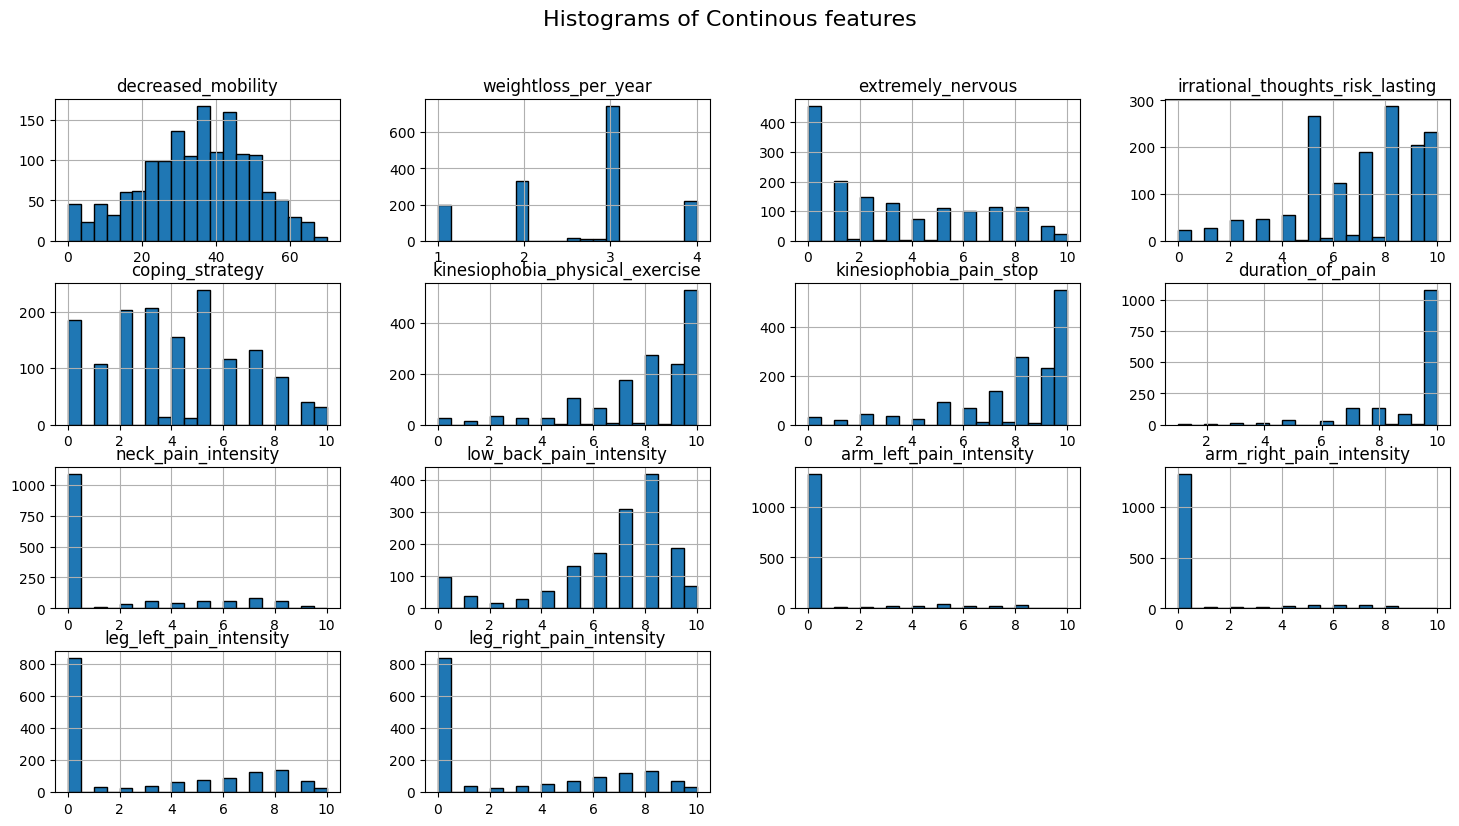

In [19]:
numeric_df = df_final.select_dtypes(include=['int64', 'float64', 'Int64'])
numeric_df = numeric_df.loc[:, (numeric_df > 1).any()]
numeric_df = numeric_df.iloc[:,1:]
numeric_df.hist(figsize=(18, 9), bins=20, edgecolor="black")
plt.suptitle("Histograms of Continous features", fontsize=16)
plt.show()



In [20]:
df_final.age.value_counts()

age
50-59    397
40-49    310
60-69    307
30-39    187
70-79    164
20-29    105
>=80      32
0-19      25
Name: count, dtype: int64

In [21]:
# numeric_df = numeric_df.loc[:, (numeric_df > 1).any()]
# numeric_df = numeric_df.iloc[:,1:]
# num_cols = len(numeric_df.columns)

# # Determine grid size (e.g., square layout)
# cols = 4
# rows = math.ceil(num_cols / cols)

# # Set figure size based on grid size
# plt.figure(figsize=(cols * 4, rows * 3))

# # Create subplots
# for i, col in enumerate(numeric_df.columns, 1):
#     plt.subplot(rows, cols, i)
#     sns.boxplot(y=numeric_df[col])
#     plt.title(col)
#     plt.tight_layout()

# plt.show()


# """Considerando le varie distribuzioni ed il n di outliers in __pain sarebbe utile convertire queste features in binarie (got pain, no pain).
#     neck, leg, arm pain"""
# df_merged.describe()


# Feature Engineering 
- Conversion of arm,leg,neck pain in binary columns based on the values of '__left_pain_intensity', '__right_pain_intensity'
- Create new 'kinesiophobia' column based on the values of 'kinesiophobia_pain_stop' and 'kinesiophobia_physical_exercise'

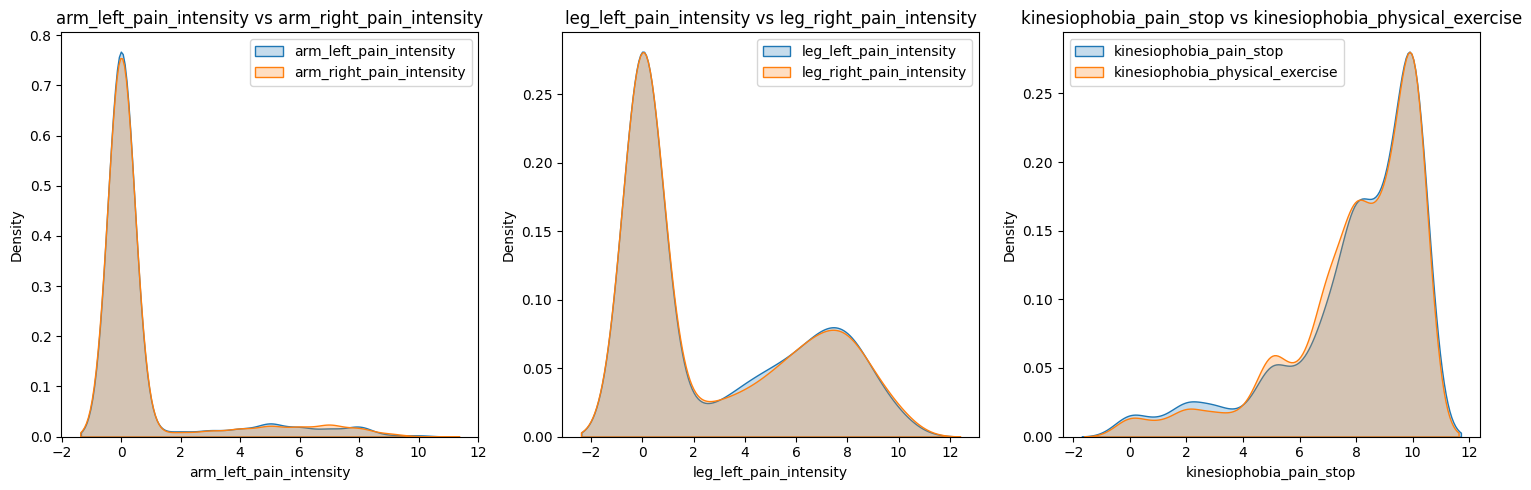

In [35]:
def check_distributions(DF,col_pairs,nrows=1,ncols=3,figsize=(15, 5)):
    """Check distributions of the features in the pairs."""
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()
    
    for idx, (col1, col2) in enumerate(col_pairs):
        ax = axes[idx]
        sns.kdeplot(data=DF, x=col1, label=col1, fill=True, ax=ax)
        sns.kdeplot(data=DF, x=col2, label=col2, fill=True, ax=ax)
        ax.set_title(f"{col1} vs {col2}")
        ax.legend()
    plt.tight_layout()
    plt.show()
    
col_groups = [
    ('arm_left_pain_intensity', 'arm_right_pain_intensity'),
    ('leg_left_pain_intensity', 'leg_right_pain_intensity'),
    ('kinesiophobia_pain_stop', 'kinesiophobia_physical_exercise')
]

check_distributions(df_final, col_groups)


###  Convert arm, leg, neck (intensity) continous features to binary columns

This is due to the similarity of the distributions and the fact that the values have a skewed distribution around the '0' value

In [ ]:
df_final['arm_pain'] = ((df_final['arm_left_pain_intensity'] > 0) | 
                         (df_final['arm_right_pain_intensity'] > 0)).astype('int64')

df_final['leg_pain'] = ((df_final['leg_left_pain_intensity'] > 0) | 
                         (df_final['leg_right_pain_intensity'] > 0)).astype('int64')

df_final['neck_pain'] = ((df_final['neck_pain_intensity'] > 0)).astype('int64')

df_new = df_final.drop(columns={'arm_left_pain_intensity','arm_right_pain_intensity','leg_left_pain_intensity','leg_right_pain_intensity','neck_pain_intensity'})

### Create new continous Variable Kinesiophobia taking the mean value between the two distributions
This is due to the similarity of the two distributions

In [38]:
df_new['kinesiophobia'] = df_new[['kinesiophobia_pain_stop', 'kinesiophobia_physical_exercise']].mean(axis=1)
df_new = df_new.drop(columns={'kinesiophobia_pain_stop','kinesiophobia_physical_exercise'})
len(df_final.columns)-1, len(df_new.columns)-1      # We go from 33 to 27 features 

(33, 27)

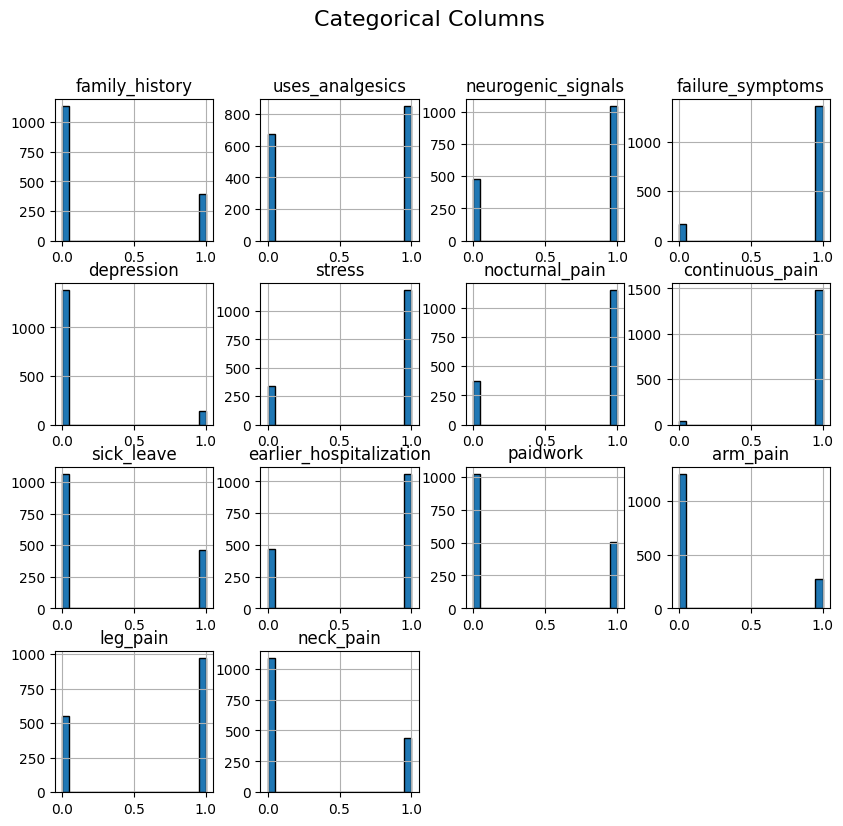

In [44]:
# Categorical
categorical_columns = [col for col in df_new.columns if df_new[col].nunique() < 3]
plot_df = df_new[categorical_columns]
plot_df.hist(figsize=(10, 9), bins=20, edgecolor="black")
plt.suptitle("Categorical Columns", fontsize=16)
plt.show()

In [47]:
## TO CHECK
# Convert numeric columns to float
numeric_df = df_new.select_dtypes(include=['int64', 'float64', 'Int64'])
numeric_df = numeric_df.loc[:, (numeric_df > 1).any()]
numeric_df = numeric_df.iloc[:,1:]
# print(numeric_df.columns)
df_new[numeric_df.columns] = df_new[numeric_df.columns].astype(float)

# 2. Identify non-numeric columns (excluding 'age')
non_numeric_cols = df_new.columns.difference(numeric_df.columns).difference(['age'])

# 3. Convert those to Int64
df_new[non_numeric_cols] = df_new[non_numeric_cols].apply(pd.to_numeric, errors='coerce').astype('int64')
#df_new.dtypes


In [131]:
df_new.columns

Index(['treatment', 'family_history', 'serious_disease', 'fever',
       'uses_analgesics', 'uses_corticosteroids', 'neurogenic_signals',
       'decreased_mobility', 'weightloss_per_year', 'loss_muscle_strength',
       'failure_symptoms', 'depression', 'extremely_nervous', 'stress',
       'irrational_thoughts_risk_lasting', 'coping_strategy', 'nocturnal_pain',
       'continuous_pain', 'duration_of_pain', 'low_back_pain_intensity',
       'sick_leave', 'earlier_hospitalization', 'paidwork', 'age', 'arm_pain',
       'leg_pain', 'neck_pain', 'kinesiophobia', 'age_numeric'],
      dtype='object')

## One-Hot Encoding of Age Column

In [50]:
#age_encoded = pd.get_dummies(df_new['age'], prefix='age')
age_map = {
    '0-19': 10,
    '20-29': 25,
    '30-39': 35,
    '40-49': 45,
    '50-59': 55,
    '60-69': 65,
    '70-79': 75,
    '>=80': 85
}

df_new['age_numeric'] = df_new['age'].map(age_map)

# Dataset Splitting
-  remember to add the imputer on the train dataset

In [51]:
from sklearn.model_selection import train_test_split

features_to_use = df_new.drop(columns=['treatment', 'age'])
X = features_to_use.reset_index(drop=True)
y = df_new['treatment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


## Feature Scaling

In [52]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Over Sampling & Under Sampling

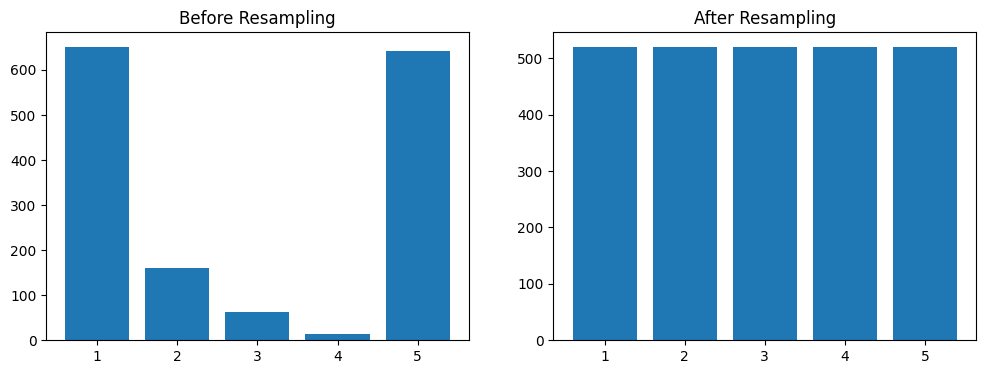

In [78]:
from imblearn.over_sampling import SMOTE
from collections import Counter

def plot_distribution(y_before, y_after):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    ax[0].bar(np.unique(y_before), [Counter(y_before)[i] for i in np.unique(y_before)])
    ax[0].set_title("Before Resampling")

    ax[1].bar(np.unique(y_after), [Counter(y_after)[i] for i in np.unique(y_after)])
    ax[1].set_title("After Resampling")

    plt.show()

smote = SMOTE(sampling_strategy='not majority', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

plot_distribution(y, y_train_res)

# Feature Analysis

## PCA: Principal Component Analysis

In [97]:
from sklearn.decomposition import PCA

pca = PCA(n_components=6)
X_pca = pca.fit_transform(X_train_res)

pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
pca_df['treatment'] = df_new['treatment'].reset_index(drop=True)


  Principal Component                       Top Feature
0                 PC0                       age_numeric
1                 PC1                decreased_mobility
2                 PC2                 extremely_nervous
3                 PC3  irrational_thoughts_risk_lasting
4                 PC4                   coping_strategy
5                 PC5           low_back_pain_intensity


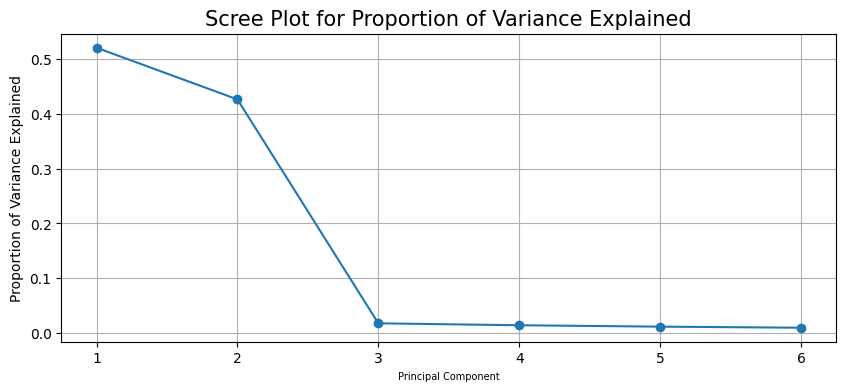

In [98]:
eigenvalues = pca.explained_variance_
prop_var = eigenvalues / np.sum(eigenvalues)
plt.figure(figsize=(10,4))
plt.plot(np.arange(1, len(prop_var)+1), 
                   prop_var, marker='o')
plt.xlabel('Principal Component',size = 7)
plt.ylabel('Proportion of Variance Explained', size = 10)
plt.title('Scree Plot for Proportion of Variance Explained',size = 15)
plt.grid(True)

# loadings (PCA components)
pca_components = pd.DataFrame(
    pca.components_,
    columns=X.columns,
    index=[f'PC{i}' for i in range(pca.n_components_)]
)

# Get most important feature per PC
top_features = pca_components.abs().idxmax(axis=1).reset_index()
top_features.columns = ['Principal Component', 'Top Feature']

print(top_features)

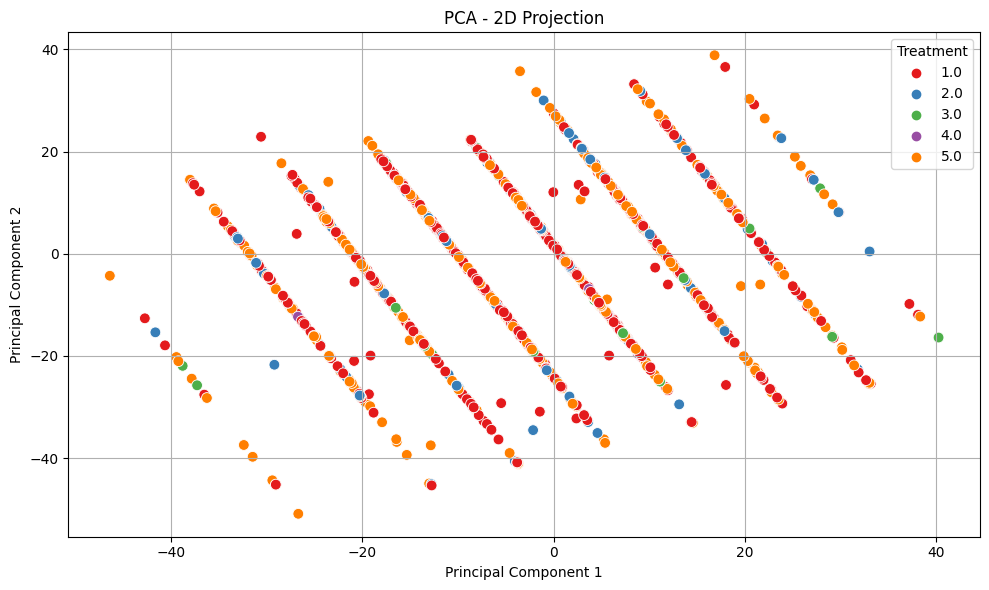

In [ ]:
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_train_res)
pca_2d_df = pd.DataFrame(X_pca_2d, columns=['PC1', 'PC2'])
pca_2d_df['treatment'] = df_new['treatment'].reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_2d_df, x='PC1', y='PC2', hue='treatment', palette='Set1', s=60)
plt.title('PCA - 2D Projection')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Treatment')
plt.grid(True)
plt.tight_layout()
plt.show()


# Modeling

## MultiNomial Logit Regression

- ricordarsi di eliminare le features correlated

In [92]:
strong_corr

fever            uses_corticosteroids    0.83
serious_disease  fever                   0.81
                 uses_corticosteroids    0.72
fever            uses_analgesics        -0.64
sick_leave       paidwork                0.53
uses_analgesics  uses_corticosteroids   -0.51
dtype: float64

In [91]:
# import statsmodels.api as sm


# ### use X_train_res, y_train_res

# # Use scaled features or PCA (replace X_scaled with X_pca if needed)
# X = pd.DataFrame(X_scaled, columns=features_to_use.columns)  # features_final = all final features used
# y = df_new['treatment'].reset_index(drop=True)

# # Add intercept for statsmodels
# X = sm.add_constant(X)

# # Fit logistic regression
# logit_model = sm.MNLogit(y, X)
# result = logit_model.fit()

# print(result.summary())


## Random Forest

In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

model = RandomForestClassifier(random_state=42)
model.fit(X_train_res, y_train_res)


y_pred = model.predict(X_test_scaled)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("accuracy: ", model.score(X_test_scaled, y_test))

###print("Confusion Matrix:\n")
##print(confusion_matrix(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

           1       0.43      0.99      0.60       131
           2       0.50      0.03      0.06        32
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00       128

    accuracy                           0.43       306
   macro avg       0.19      0.20      0.13       306
weighted avg       0.24      0.43      0.26       306

accuracy:  0.42810457516339867


In [108]:

model = RandomForestClassifier(random_state=42)
model.fit(X_pca, y_train_res)


y_pred = model.predict(X_test_scaled)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("accuracy: ", model.score(X_test_scaled, y_test))

ValueError: X has 27 features, but RandomForestClassifier is expecting 2 features as input.

In [ ]:

# # Aggiungi il modello alla pipeline esistente
# pipeline.steps.append(('model', RandomForestClassifier()))
# # Ora puoi fare fit completo
# pipeline.fit(X, y)

In [55]:
# Pipeline completa
# pipeline = ImbPipeline(steps=[
#     ('imputer', IterativeImputer(max_iter=50, skip_complete=True)),
#     ('scaler', StandardScaler()),
#     ('smote', SMOTE(random_state=42)),
#     ('classifier', RandomForestClassifier(random_state=42))  # oppure SVC(), LogisticRegression(), ecc.
# ])

In [58]:
### Per Logistic regression e PCA creiamo BINS per age

# One-hot encode 'age' into multiple binary columns
#age_encoded = pd.get_dummies(df_new['age'], prefix='age')
# df_new = pd.concat([df_new.drop(columns='age'), age_encoded], axis=1)
#features_final = df_new.drop(columns=['treatment'])


# Using Pipeline

ValueError: Shape of passed values is (3255, 29), indices imply (3255, 30)